Import all necessary packages, check cuda

In [1]:
import torch
from torch.utils.data import DataLoader

from GPUtil import showUtilization as gpu_usage
from numba import cuda

import os
import tqdm
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import librosa
import librosa.display

from AutoEncoderClass import *
from CAEclass import *
import torchinfo

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Get user path to data, create train, validation and test datasets

In [2]:
def train_val_test(dataset_path = None, cases = [], channels = []):
    data_csv = pd.read_csv(dataset_path)
    
    
    data_pd = pd.DataFrame()
    for case_number in cases: #get corresponding case numbers
        data_pd = pd.concat([data_pd, data_csv[(data_csv["Case"] == "case"+str(case_number))] ])
    
    data_pd = data_pd[data_pd['Channel'].isin(channels)]  #get corresponding channel numbers
    
    #train data only needs normal data, validation and test data need normal and abnormal data
    data_normal = data_pd[(data_pd["norm/ab"] == "normal")]
    data_abnormal = data_pd[(data_pd["norm/ab"] == "abnormal")]
        
    train_dataset, interm_dataset  = train_test_split(data_normal, test_size=0.2, shuffle = True)
    data_abnormal = pd.concat([data_abnormal, interm_dataset])
    validation_dataset, test_dataset= train_test_split(data_abnormal, test_size=0.8, shuffle= True) #only small validation

    return shuffle(train_dataset), shuffle(validation_dataset), shuffle(test_dataset)

    
datapath = r'C:\Users\brech\THESIS_local\ToyADMOS\ToycarCSV.csv'
train_dataset, validation_dataset, test_dataset = train_val_test(dataset_path = datapath, cases=[2], channels = ["ch1"])

In [3]:
train_dataset

,Full Sample Name,Toytype,Case,norm/ab,IND/CNT,Channel,sample_ID
7344,010366_ToyCar_case2_normal_IND_ch1_0366.wav,ToyCar,case2,normal,IND,ch1,366
7674,010812_ToyCar_case2_normal_IND_ch1_0812.wav,ToyCar,case2,normal,IND,ch1,812
7191,010166_ToyCar_case2_normal_IND_ch1_0166.wav,ToyCar,case2,normal,IND,ch1,166
7842,011042_ToyCar_case2_normal_IND_ch1_1042.wav,ToyCar,case2,normal,IND,ch1,1042
7230,010220_ToyCar_case2_normal_IND_ch1_0220.wav,ToyCar,case2,normal,IND,ch1,220
...,...,...,...,...,...,...,...
7491,010559_ToyCar_case2_normal_IND_ch1_0559.wav,ToyCar,case2,normal,IND,ch1,559
6803,010325_ToyCar_case2_normal_IND_ch1_0325.wav,ToyCar,case2,normal,IND,ch1,325
7032,011203_ToyCar_case2_normal_IND_ch1_1203.wav,ToyCar,case2,normal,IND,ch1,1203
7445,010495_ToyCar_case2_normal_IND_ch1_0495.wav,ToyCar,case2,normal,IND,ch1,495


datasets are of the form: Full Sample Name, Toytype,  Case,	norm/ab, IND/CNT, Channel, sample_ID

In [4]:
#helper functions 
def find_path_to_wav(full_sample_name):
    for root, dirs, files in os.walk(os.path.dirname(datapath)):
        for name in files:
            if name == full_sample_name:
                path_to_wavFile = os.path.abspath(os.path.join(root, name))
                return path_to_wavFile


def get_sample_waveform_normalised(full_sample_name, start = 0, stop = 11):
    #returns waveform values, cut to seconds going from start to stop
    sample_path = find_path_to_wav(full_sample_name)
    waveform, sample_rate = librosa.load(sample_path, sr= None)
    waveform = waveform[int(start*sample_rate): int(stop*sample_rate)]
        
    return librosa.util.normalize(waveform)

In [5]:
X_train_wav = train_dataset["Full Sample Name"].values
X_test_wav = test_dataset["Full Sample Name"].values
X_valid_wav = validation_dataset["Full Sample Name"].values

#when using the linear AE
# batch_train = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_train_wav]) # hier wss nog resizen voor CAE
# batch_test = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_test_wav])
# batch_val = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_valid_wav])

#when using the CAE
batch_train = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_train_wav]) # hier wss nog resizen voor CAE
batch_test = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_test_wav])
batch_val = np.array([get_sample_waveform_normalised(elem,4,4.5) for elem in X_valid_wav])

batch_train_reshaped =  np.reshape(batch_train,(len(batch_train),1,8000,1))
batch_test_reshaped =  np.reshape(batch_test,(len(batch_test),1,8000,1))
batch_val_reshaped =  np.reshape(batch_val,(len(batch_val),1,8000,1))

#when using the linear AE
# X_train = DataLoader(batch_train, batch_size = 64, shuffle = False)
# X_test = DataLoader(batch_test, batch_size = 64, shuffle = False)
# X_val = DataLoader(batch_val, batch_size = 64, shuffle = False)

X_train = DataLoader(batch_train_reshaped, batch_size = 64, shuffle = False)
X_test = DataLoader(batch_test_reshaped, batch_size = 64, shuffle = False)
X_val = DataLoader(batch_val_reshaped, batch_size = 64, shuffle = False)

Y_train = train_dataset["norm/ab"]
Y_test = test_dataset["norm/ab"]
Y_val = validation_dataset["norm/ab"]

#AFTER THIS POINT NO SHUFFLING IS DONE, SO DATA FROM XTRAIN LINES UP YTRAIN, etc...

for example, batch_test is (1709,16000)
with batch size of 32, this gives 53.4 (so 54) arrays, each with 32 samples 

so 1 batch: 32 samples, size (32, 16000)
==> 54 batches

idea is to feed batch per batch to the neural net


for batch_train (4320,16000) this would give 135 batches (each with 32 samples)

Set autoencoder parameters

In [ ]:
#choose the model by choosing which cell to run
model = AutoEncoder(8000).to(device=device) #assume 0.5 sec of waveform
torchinfo.summary(model)

In [6]:
model = CAE().to(device=device)
torchinfo.summary(model, input_size=(1,1, 8000, 1)) #batch_size, channel, rows,cols

Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      [1, 1, 8000, 1]           --
├─Sequential: 1-1                        [1, 512, 250, 1]          --
│    └─Conv2d: 2-1                       [1, 32, 8000, 1]          128
│    └─Tanh: 2-2                         [1, 32, 8000, 1]          --
│    └─MaxPool2d: 2-3                    [1, 32, 4000, 1]          --
│    └─Conv2d: 2-4                       [1, 64, 4000, 1]          6,208
│    └─Tanh: 2-5                         [1, 64, 4000, 1]          --
│    └─MaxPool2d: 2-6                    [1, 64, 2000, 1]          --
│    └─Conv2d: 2-7                       [1, 128, 2000, 1]         24,704
│    └─Tanh: 2-8                         [1, 128, 2000, 1]         --
│    └─MaxPool2d: 2-9                    [1, 128, 1000, 1]         --
│    └─Conv2d: 2-10                      [1, 256, 1000, 1]         98,560
│    └─Tanh: 2-11                        [1, 256, 1000, 1]         --
│  

In [7]:
model_loss = nn.MSELoss()    #?nn.L1Loss() best type of loss for sound?, MSE loss seems to result in lower loss
learning_rate = 0.0001  #0.0001 seems best so far
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
epochs = 150
losses = []
avg_val_losses = []


def train(epochs, model, model_loss):
    for epoch in tqdm.tqdm(range(epochs)):
        
        for batch_idx, data in enumerate(X_train):
            #print(len(data), data)
            
            model.train(True)
            # Zero your gradients for every batch!
            model.zero_grad()
            #for param in model.parameters(): #instead of model.zero_grad: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html#:~:text=implement%20this%20optimization.-,Use%20parameter.grad,-%3D%20None%20instead%20of
            #    param.grad = None
            # Make predictions for this batch
            data_gpu = data.to(device= device)
            outputs = model(data_gpu)
    
            # Compute the loss and its gradients
            loss = model_loss(outputs, data_gpu)
            loss.backward()
            optimizer.step()
           
            losses.append(loss.item())
            #del loss 
            #del data #free memory
            #del outputs
            
            model.train(False)

        
        #hier validation data gebruiken, gets run once per epoch
        #get average loss value of the validation data
        running_val_loss = []
        for val_data in X_val:
            val_data_gpu = val_data.to(device=device)
            val_outputs = model(val_data_gpu)
            val_loss = model_loss(val_outputs, val_data_gpu)
            
            running_val_loss.append(val_loss.item())

        avg_val_losses.append(np.average(running_val_loss))

train(model=model, epochs=epochs, model_loss=model_loss)


100%|██████████| 150/150 [06:56<00:00,  2.78s/it]


Plot the losses 

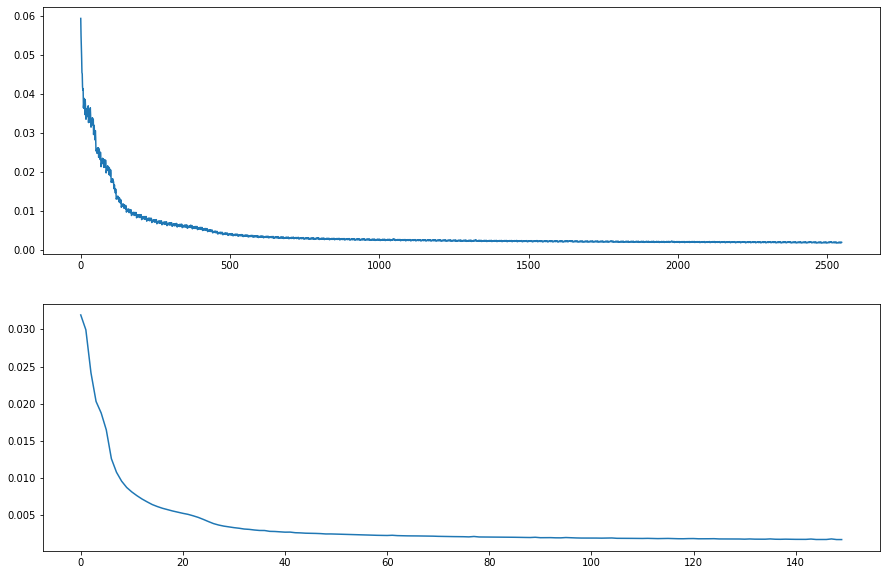

In [9]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
plt.plot(losses)

plt.subplot(2,1,2)
plt.plot(avg_val_losses)
plt.show()

Keep track of how good the model did, compare file

In [10]:
from datetime import datetime
now = datetime.now()
lines = [now, model, model_loss,learning_rate,epochs,optimizer,losses[-100:], avg_val_losses ]
with open('All results.txt', 'a') as f:
    for line in lines:
        f.write(str(line))
        f.write('\n')
    f.write('\n')

Use the model on the test data and get a score(normal_score/anomaly_score) to hopefully see a difference:\
https://neptune.ai/blog/pytorch-loss-functions


In [11]:
def score(dataset, scoring_function):
    scores_normal = [] #scores of each waveform in the test dataset
    scores_abnormal = []
    
    for line_of_data in dataset.iloc():
        waveform = np.array(get_sample_waveform_normalised(line_of_data["Full Sample Name"], 4, 4.5))
        waveform = np.reshape(waveform,(1,1,8000,1))
        waveform_gpu = torch.FloatTensor(waveform).to(device=device)

        predicted_waveform = model(waveform_gpu)
        error = scoring_function(predicted_waveform,waveform_gpu)
        
        if line_of_data["norm/ab"] == "normal":
            scores_normal.append(error.detach().cpu().numpy().item()) 
        
        if line_of_data["norm/ab"] == "abnormal":
            scores_abnormal.append(error.detach().cpu().numpy().item()) 
   
    return scores_normal, scores_abnormal

MSE_scores_normal, MSE_scores_abnormal = score(test_dataset, scoring_function = nn.MSELoss())
L1_scores_normal, L1_scores_abnormal = score(test_dataset, scoring_function = nn.L1Loss())
CEL_scores_normal, CEL_scores_abnormal =score(test_dataset, scoring_function =nn.CrossEntropyLoss()) #definately worst



<function matplotlib.pyplot.show(close=None, block=None)>

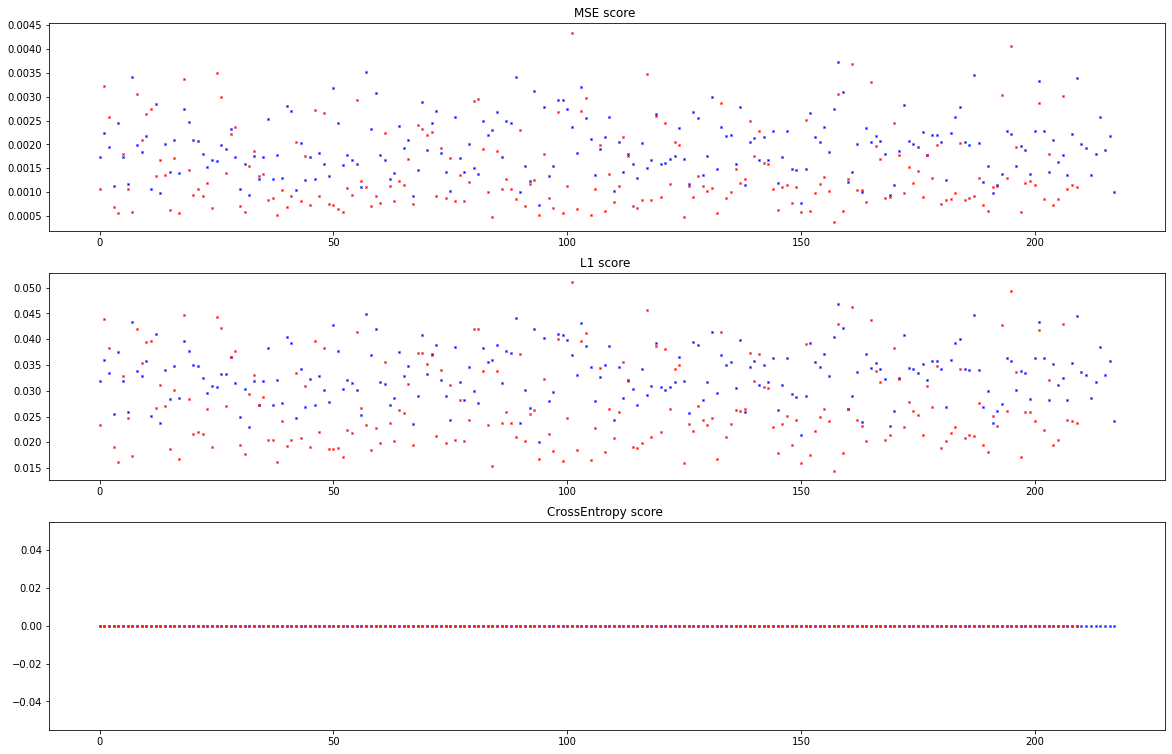

In [12]:
plt.figure(figsize=(20,13))

plt.subplot(3,1,1)
plt.plot(range(len(MSE_scores_normal)), MSE_scores_normal, 'bx',linewidth=1, markersize=2) 
plt.plot(range(len(MSE_scores_abnormal)), MSE_scores_abnormal, 'rx', linewidth=1, markersize=2 ) 
plt.title("MSE score ")


plt.subplot(3,1,2)
plt.plot(range(len(L1_scores_normal)), L1_scores_normal, 'bx',linewidth=1, markersize=2) 
plt.plot(range(len(L1_scores_abnormal)), L1_scores_abnormal, 'rx', linewidth=1, markersize=2 ) 
plt.title("L1 score ")

plt.subplot(3,1,3)
plt.plot(range(len(CEL_scores_normal)), CEL_scores_normal, 'bx',linewidth=1, markersize=2) 
plt.plot(range(len(CEL_scores_abnormal)), CEL_scores_abnormal, 'rx', linewidth=1, markersize=2 ) 
plt.title("CrossEntropy score ")

plt.show

In [13]:
#get a best boundary between noral and abnormal scores

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

#RESCALE DATA! met standardscaler
L1_scores_normal, L1_scores_abnormal = np.array(L1_scores_normal), np.array(L1_scores_abnormal)
L1_scores_normal, L1_scores_abnormal = L1_scores_normal.reshape(-1, 1), L1_scores_abnormal.reshape(-1,1)

scaler_normal = StandardScaler()
scaler_normal.fit_transform(L1_scores_normal)

scaler_abnormal = StandardScaler()
scaler_abnormal.fit_transform(L1_scores_abnormal)

L1_all_scores = np.append(L1_scores_abnormal, L1_scores_normal).reshape(-1, 1) # first abnormal(-1), then normal(1)
L1_all_results = np.ravel(np.concatenate((np.ones_like(L1_scores_abnormal)*(-1), np.ones_like(L1_scores_normal)), axis=0))

################################################################
svc = svm.SVC(kernel= 'rbf', probability = True) # Kernel
svc.fit(L1_all_scores, L1_all_results)
result = svc.predict(L1_all_scores)

result_proba = svc.predict_proba(L1_all_scores)[:,1] #predicted chance of being 1 (=Normal)


#get correct percentage(True positive and true negative)

(L1_all_results == result).sum()/float(len(result))


0.7546728971962616

get the ROC and AUC plots
ROC_AUC curve of andere general methode om het model te testen\
andere methode PR_AUC
+confusion matrix

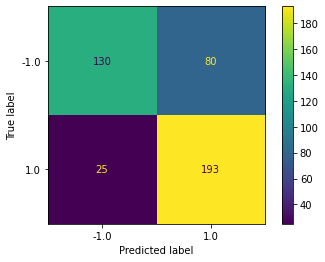

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(L1_all_results, result, labels = svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = svc.classes_)
disp.plot()
plt.show()



0.7521843599825251


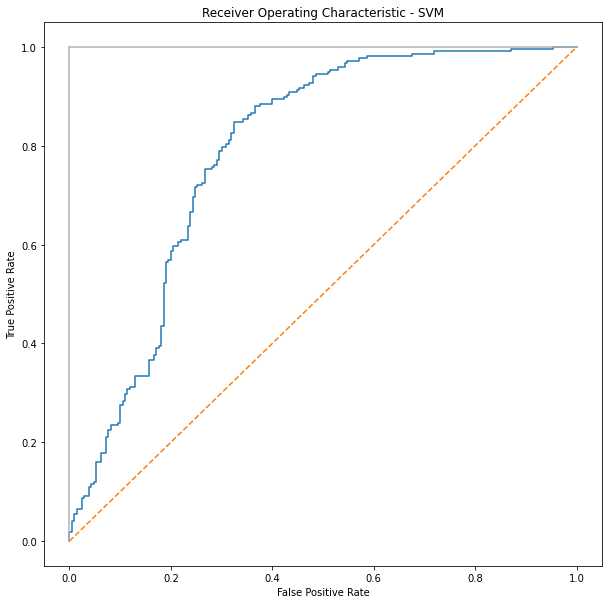

In [16]:
from sklearn.metrics import plot_roc_curve, roc_auc_score, RocCurveDisplay, roc_curve
print(roc_auc_score(L1_all_results,result))

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(L1_all_results, result_proba)
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()